# 1D Convolutional Neural Network
In this notebook we implement a first attempt at next token prediction using a neural network. To align with previous weeks in this course we choose a simple 1D [convolutional neural network (CNN)](http://d2l.ai/chapter_convolutional-neural-networks/index.html). The motivation behind this is that by composing convolutions we can create a [receptive field](http://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html#feature-map-and-receptive-field) on our sequence context that is more efficient in its parameter use than our previous n-gram Markov model, thereby allowing longer sequence context to be used.

In [7]:
# All dependencies for the entire notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

DEVICE = torch.device("mps")

## Data

In [ ]:
# Download the tiny shakespeare dataset
!wget -nc https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

We use a character level tokenizer and a dataset class to select (and one-hot encode) a context of a given size and the next token to predict.

In [2]:
class CharacterTokenizer:
    """Character level tokenizer that enumerates unique characters in a training text"""
    def __init__(self, encoding_dict: dict[str, int]=None):
        if encoding_dict is None:
            self.encoding_dict = dict()
        else:
            self.encoding_dict = encoding_dict

    def __repr__(self):
        return f'CharacterTokenizer(vocab_size={self.vocab_size})'

    @property
    def decoding_dict(self) -> dict[int, str]:
        """Decoding dict is implemented as property to automatically sync with changed encoding dict"""
        return {token:char for char,token in self.encoding_dict.items()}

    @property
    def vocab_size(self) -> int:
        return len(self.encoding_dict)

    def get_vocab(self) -> dict[str, int]:
        return self.encoding_dict

    def train(self, data: str) -> None:
        """Train on a piece of text by enumerating unique characters"""
        chars = sorted(set(data))
        self.encoding_dict = {char:token for token,char in enumerate(chars)}

    def encode(self, data: str) -> list[int]:
        """Convert text to tokens"""
        return [self.encoding_dict.get(char, -1) for char in data]

    def decode(self, tokens: list[int]) -> str:
        """Convert tokens to text"""
        return ''.join(self.decoding_dict.get(token, '<unk>') for token in tokens)

class CharacterDataset:
    def __init__(self, data: str, tokenizer: CharacterTokenizer, context_size: int=256):
        self.data = data
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.context_size = context_size

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        context_size = self.context_size
        return f'CharacterDataset({n_chars=}, {context_size=}, {vocab_size=})'

    @classmethod
    def from_textfile(cls, filename: str, context_size: int=256) -> 'CharacterDataset':
        tokenizer = CharacterTokenizer()
        with open(filename, 'r') as fh:
            data = fh.read()
            tokenizer.train(data)
            return cls(data, tokenizer, context_size=context_size)

    def __len__(self) -> int:
        return len(self.data) - self.context_size

    def __getitem__(self, idx: int) -> torch.tensor:
        # grab a chunk of context_size + 1 characters from the data
        chunk = self.data[idx:idx + self.context_size + 1]
        # encode every character to an integer
        tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # Onehot encode, transpose because Conv1D takes (batch, channels, length) as input dims: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        x = F.one_hot(tokens[:-1], num_classes=self.vocab_size).type(torch.float32).T
        # Use last character as target
        y = tokens[-1:]
        return x,y

dataset = CharacterDataset.from_textfile('./input.txt', context_size=32)
x,y = dataset[0]
x.shape,y.shape

(torch.Size([65, 32]), torch.Size([1]))

### Exercise 1
Interpret the shapes of `x` and `y` in the above codeblock

## Model
Below we implement our 1D convolutional neural network for next character prediction. The `forward` and `generate` methods are used in a similar way to what we used for the n-gram markov prediction model. Because our CNN relies on a input of fixed size, the `generate` method starts with `context_size` newline characters to 'kickstart' the generating process. These initial newlines are subsequently omitted from returned output. 

> _Note:_ The artificial large number of newlines to kickstart the sample generation is not in the training set. You could wonder to what extent this impacts our samples.

### Exercise 2
Add the 1D CNN to the provided implementation below. Create two convolution blocks of the specified number of channels that use [Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), and [MaxPool1d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html), followed by a [linear projection](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to the output dimensionality (vocab_size). Use a convolution kernel size of 3, with padding to keep the output the same size. Use max-pooling with a kernel size of 2 and a stride to keep the same output size. Train your model using the training codeblock. What training and test loss does your 'simple' 1D convolution net achieve?

In [3]:
class CNN1D(nn.Module):
    """1D Convolutional Neural Network for next token prediction"""
    def __init__(self, vocab_size: int, context_size: int, conv_channels: int=128, use_bias: bool=False):
        super().__init__()
        assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
        self.vocab_size = vocab_size
        self.context_size = context_size
        #self.cnn = # IMPLEMENT ME
        self.cnn = nn.Sequential(
            # conv block 1
            nn.Conv1d(in_channels=self.vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv block 2
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # output projection
            nn.Flatten(1, -1),
            # Divide by 4 due to maxpooling twice
            nn.Linear(in_features=int(conv_channels * self.context_size / 4), out_features=self.vocab_size, bias=use_bias)
        )

    def forward(self, X: torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
        """Predict logits of next character conditioned on context_size previous characters"""
        logits = self.cnn(X)
        loss = None if targets is None else F.cross_entropy(logits, targets.view(-1), ignore_index=-1)
        return logits,loss

    def generate(self, sample_length: int=256) -> list[int]:
        """Generate sample of tokens"""
        device = next(self.parameters()).device
        # Start generating with n=context_size newline tokens, these will later be omitted
        idx = torch.zeros((1, self.context_size), dtype=torch.long, device=device)

        for _ in trange(sample_length, desc='Sampling'):
            # onehot encode the last context_size tokens
            context_tokens = idx[:, -self.context_size:]
            input = F.one_hot(context_tokens, self.vocab_size).to(torch.float).transpose(1,2) # transpose because of Conv1D shape requirements
            # forward model and calculate token probabilities
            logits, _ = model(input)
            probs = F.softmax(logits, dim=-1)
            # sample next token
            idx_next = torch.multinomial(probs, num_samples=1)
            # append generated token to current sample
            idx = torch.cat([idx, idx_next], dim=1)

        # Omit first context_size tokens (these were all newlines to get the sampling started)
        return idx[0, self.context_size:].tolist()

# Create a sample with an untrained model for comparison/testing
model = CNN1D(dataset.vocab_size, context_size=dataset.context_size)
sample = model.generate()
print(dataset.tokenizer.decode(sample))

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]

I';
Ad;ZAW.DvYR!
DivIfmEBte,QYnfntYp KP,YbFw.PDKi.nGdxQ!?s
'rNy?WpQHzT3DK&vu GnInul'
jmvb;3qyMuyo&NQpNuxpnXI$hukznpYw CEIxhZBuy:M,k!f!HJQieQJwXySU.NyH$TfAqVyB.JGuEufzNb-JfhNXj,SGYftLPFzYOovo3,T?WHgaP
E-E:D3F;PRODitmwCZiP
m-:&rcJLbJNGy$&MW,PYPfK:LH.rwL,3I3l


## Training

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

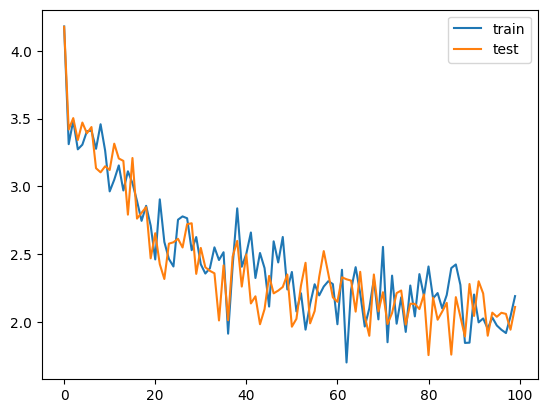

In [8]:
train_steps = 2000
batch_size = 64
context_size = 32
train_frac = 0.8


dataset = CharacterDataset.from_textfile('./input.txt', context_size=context_size)
train_dataset,test_dataset = random_split(dataset, (train_frac, 1 - train_frac))

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, num_samples=train_steps * batch_size),
    batch_size=batch_size,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset),
    batch_size=batch_size,
)
test_dataloader = iter(test_dataloader)

model = CNN1D(vocab_size=dataset.vocab_size, context_size=dataset.context_size)
model.to(DEVICE)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

train_losses = []
test_losses = []

for i,(x,y) in enumerate(tqdm(train_dataloader, desc='Training')):
    x,y = x.to(DEVICE), y.to(DEVICE)
    # forward model and calculate loss
    _,loss = model(x,y)
    # save train and test loss every 20 steps
    if i % 20 == 0:
        train_losses.append(loss.item())
        test_x, test_y = next(test_dataloader)
        _,test_loss = model(test_x.to(DEVICE), test_y.to(DEVICE))
        test_losses.append(test_loss.item())
    # backprop and update the parameters
    model.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

## Evaluation

In [9]:
sample = model.generate(sample_length=256)
print(dataset.tokenizer.decode(sample))

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]

OO:O:
Toun ant whop ttetwor.
Sike eived frouidiy prolillean.

QIICANTHUDRODO:
OnE My Pmronter, Paking'y sotweed themring dord.
Nimseccisesinttuninnjre.
For stming ther coupor veecin a be, chome gars but herd soung urlt.

OUUWUINO:
Or', miem a, sist iar wem


## Answers

### Exercise 1
- `x` shape: one hot encoded sequence of context length, so the shape is `vocab_size` x `context_length`
- `y` shape: single next token

### Exercise 2
An example 1D CNN implementation is given below. After training for 2000 iterations using batch_size=64 and context_size=32, this achieves a training and test loss of 2.0 - 2.5.

In [ ]:
self.cnn = nn.Sequential(
    # conv block 1
    nn.Conv1d(in_channels=self.vocab_size, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),
    # conv block 2
    nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),
    # output projection
    nn.Flatten(1, -1),
    # Divide by 4 due to maxpooling twice
    nn.Linear(in_features=int(conv_channels * self.context_size / 4), out_features=self.vocab_size, bias=use_bias)
)